## 1. Inventaire des Données

Vérifier la disponibilité de toutes les données téléchargées

In [2]:
# Imports
%pip install seaborn
import sys
sys.path.append('..')

import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.features import rasterize
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import yaml

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Modules importés")

     -------------------------------------- 294.9/294.9 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


✓ Modules importés


## 2. Charger et Examiner les Métadonnées

Vérifier les caractéristiques spatiales (résolution, CRS, extent)

In [3]:
# Chemins vers les données
data_dir = "../data/raw"

# Lister les fichiers disponibles
print("📁 Inventaire des données:\n")

# AETI (Evapotranspiration)
et_files = sorted([f for f in os.listdir(f"{data_dir}/ET") if f.endswith('.tif')])
print(f"✓ AETI (Evapotranspiration): {len(et_files)} fichiers")
for f in et_files:
    print(f"  - {f}")

# TBP (Transpiration/Biomass)
tbp_files = sorted([f for f in os.listdir(f"{data_dir}/TBP") if f.endswith('.tif')])
print(f"\n✓ TBP (Transpiration): {len(tbp_files)} fichiers")
for f in tbp_files:
    print(f"  - {f}")

# PCP (Precipitation)
pcp_files = sorted([f for f in os.listdir(f"{data_dir}/PCP") if f.endswith('.tif')])
print(f"\n✓ PCP (Précipitations): {len(pcp_files)} fichiers")
for f in pcp_files:
    print(f"  - {f}")

# LCC (Land Cover)
lcc_files = sorted([f for f in os.listdir(f"{data_dir}/LCC") if f.endswith('.tif')])
print(f"\n✓ LCC (Couverture du sol): {len(lcc_files)} fichiers")
for f in lcc_files:
    print(f"  - {f}")

# Années communes
et_years = [int(f.split('_')[-1].replace('.tif', '')) for f in et_files if 'AETI' in f]
tbp_years = [int(f.split('_')[-1].replace('.tif', '')) for f in tbp_files if 'TBP' in f]
pcp_years = [int(f.split('_')[-1].replace('.tif', '')) for f in pcp_files if 'PCP' in f]

common_years = sorted(list(set(et_years) & set(tbp_years) & set(pcp_years)))
print(f"\n📅 Années communes disponibles: {common_years}")
print(f"   Période d'analyse: {min(common_years)} - {max(common_years)}")

📁 Inventaire des données:

✓ AETI (Evapotranspiration): 6 fichiers
  - AETI_L1_2018.tif
  - AETI_L1_2019.tif
  - AETI_L1_2020.tif
  - AETI_L1_2021.tif
  - AETI_L1_2022.tif
  - AETI_L1_2023.tif

✓ TBP (Transpiration): 6 fichiers
  - TBP_L2_2018.tif
  - TBP_L2_2019.tif
  - TBP_L2_2020.tif
  - TBP_L2_2021.tif
  - TBP_L2_2022.tif
  - TBP_L2_2023.tif

✓ PCP (Précipitations): 6 fichiers
  - PCP_L1_2018.tif
  - PCP_L1_2019.tif
  - PCP_L1_2020.tif
  - PCP_L1_2021.tif
  - PCP_L1_2022.tif
  - PCP_L1_2023.tif

✓ LCC (Couverture du sol): 1 fichiers
  - LCC_ESA_2020.tif

📅 Années communes disponibles: [2018, 2019, 2020, 2021, 2022, 2023]
   Période d'analyse: 2018 - 2023


## 3. Créer le Masque Cropland

Extraire la classe 40 (Terres cultivées) d'ESA WorldCover et la rééchantillonner à la grille WaPOR

In [4]:
# Examiner un fichier AETI (référence WaPOR)
year_ref = common_years[0]
et_ref = f"{data_dir}/ET/AETI_L1_{year_ref}.tif"
lcc_file = f"{data_dir}/LCC/LCC_ESA_2020.tif"

print(f"📊 Métadonnées des rasters (année de référence: {year_ref})\n")

# WaPOR AETI
with rasterio.open(et_ref) as src:
    print("🌍 AETI (WaPOR Level 1):")
    print(f"  Dimensions: {src.width} x {src.height} pixels")
    print(f"  Résolution: {src.res[0]:.4f}° x {src.res[1]:.4f}°")
    print(f"  Résolution (m): ~{abs(src.res[0]) * 111320:.0f}m x ~{abs(src.res[1]) * 111320:.0f}m")
    print(f"  CRS: {src.crs}")
    print(f"  Bounds: {src.bounds}")
    print(f"  NoData: {src.nodata}")
    et_profile = src.profile
    et_transform = src.transform
    et_crs = src.crs

# ESA WorldCover
with rasterio.open(lcc_file) as src:
    print("\n🌍 LCC (ESA WorldCover):")
    print(f"  Dimensions: {src.width} x {src.height} pixels")
    print(f"  Résolution: {abs(src.res[0]):.4f}° x {abs(src.res[1]):.4f}°")
    print(f"  Résolution (m): ~{abs(src.res[0]) * 111320:.0f}m x ~{abs(src.res[1]) * 111320:.0f}m")
    print(f"  CRS: {src.crs}")
    print(f"  Bounds: {src.bounds}")
    lcc_profile = src.profile

print("\n⚠️ Note: Les résolutions sont différentes → nécessite resampling")
print(f"   WaPOR: ~{abs(et_profile['transform'][0]) * 111320:.0f}m")
print(f"   WorldCover: ~{abs(lcc_profile['transform'][0]) * 111320:.0f}m")

📊 Métadonnées des rasters (année de référence: 2018)

🌍 AETI (WaPOR Level 1):
  Dimensions: 1399 x 2560 pixels
  Résolution: 0.0029° x 0.0029°
  Résolution (m): ~326m x ~326m
  CRS: EPSG:4326
  Bounds: BoundingBox(left=7.5, bottom=30.0, right=11.5986328125, top=37.5)
  NoData: -9999.0

🌍 LCC (ESA WorldCover):
  Dimensions: 31199 x 36000 pixels
  Résolution: 0.0001° x 0.0001°
  Résolution (m): ~9m x ~9m
  CRS: EPSG:4326
  Bounds: BoundingBox(left=7.5, bottom=34.5, right=10.1, top=37.5)

⚠️ Note: Les résolutions sont différentes → nécessite resampling
   WaPOR: ~326m
   WorldCover: ~9m
🌍 AETI (WaPOR Level 1):
  Dimensions: 1399 x 2560 pixels
  Résolution: 0.0029° x 0.0029°
  Résolution (m): ~326m x ~326m
  CRS: EPSG:4326
  Bounds: BoundingBox(left=7.5, bottom=30.0, right=11.5986328125, top=37.5)
  NoData: -9999.0

🌍 LCC (ESA WorldCover):
  Dimensions: 31199 x 36000 pixels
  Résolution: 0.0001° x 0.0001°
  Résolution (m): ~9m x ~9m
  CRS: EPSG:4326
  Bounds: BoundingBox(left=7.5, bottom=3

## 4. Rééchantillonner le Masque à la Grille WaPOR

Utiliser le mode 'average' pour conserver la fraction de cropland par pixel WaPOR

In [7]:
print("🌾 Création du masque Cropland...\n")

# Charger LCC avec lecture par blocs pour économiser la mémoire
with rasterio.open(lcc_file) as src:
    lcc_transform = src.transform
    lcc_crs = src.crs
    lcc_shape = (src.height, src.width)
    
    print(f"✓ Métadonnées LCC chargées")
    print(f"  Dimensions: {src.width} x {src.height} pixels")
    
    # Calculer statistiques de classe en une seule passe (sans charger tout en mémoire)
    print("\n📊 Distribution des classes (calcul par blocs):")
    
    from collections import Counter
    class_counts = Counter()
    cropland_pixels = 0
    
    # Lire par blocs de 1000 lignes
    block_size = 1000
    for i in range(0, src.height, block_size):
        rows = min(block_size, src.height - i)
        window = rasterio.windows.Window(0, i, src.width, rows)
        block = src.read(1, window=window)
        
        # Compter les classes dans ce bloc
        unique, counts = np.unique(block, return_counts=True)
        for cls, count in zip(unique, counts):
            class_counts[int(cls)] += int(count)
        
        # Compter cropland (classe 40)
        cropland_pixels += np.sum(block == 40)
        
        if (i // block_size) % 10 == 0:
            print(f"  Traitement: {i}/{src.height} lignes...", end='\r')
    
    print(f"  Traitement: {src.height}/{src.height} lignes... ✓")

# Afficher résultats
legend = {
    10: "Arbres", 20: "Arbustes", 30: "Herbacées",
    40: "Terres cultivées", 50: "Bâti", 60: "Végétation clairsemée",
    70: "Neige/glace", 80: "Eau", 90: "Zones humides",
    95: "Mangroves", 100: "Mousses/lichens"
}

print(f"\n✓ Analyse terminée")
print(f"  Pixels cropland: {cropland_pixels:,}")
print(f"  Surface cropland: ~{cropland_pixels * 0.01 * 0.01:.0f} km²")

# Calculer total sans classe 0
total = sum(count for cls, count in class_counts.items() if cls > 0)

print("\n📈 Distribution par classe:")
for cls in sorted([c for c in class_counts.keys() if c > 0]):
    count = class_counts[cls]
    pct = (count / total) * 100
    print(f"  {cls:3d} - {legend.get(cls, 'Inconnu'):20s}: {pct:5.1f}%")

print("\n💡 Note: Masque cropland sera créé lors du resampling (étape suivante)")
print("   Pas de stockage du masque haute résolution en mémoire")

🌾 Création du masque Cropland...

✓ Métadonnées LCC chargées
  Dimensions: 31199 x 36000 pixels

📊 Distribution des classes (calcul par blocs):
  Traitement: 36000/36000 lignes... ✓

✓ Analyse terminée
  Pixels cropland: 160,372,119
  Surface cropland: ~16037 km²

📈 Distribution par classe:
   10 - Arbres              :   3.5%
   20 - Arbustes            :   2.0%
   30 - Herbacées           :  11.6%
   40 - Terres cultivées    :  16.6%
   50 - Bâti                :   1.5%
   60 - Végétation clairsemée:  30.5%
   80 - Eau                 :  33.9%
   90 - Zones humides       :   0.4%

💡 Note: Masque cropland sera créé lors du resampling (étape suivante)
   Pas de stockage du masque haute résolution en mémoire
  Traitement: 36000/36000 lignes... ✓

✓ Analyse terminée
  Pixels cropland: 160,372,119
  Surface cropland: ~16037 km²

📈 Distribution par classe:
   10 - Arbres              :   3.5%
   20 - Arbustes            :   2.0%
   30 - Herbacées           :  11.6%
   40 - Terres cultivées

## 5. Visualiser le Masque Cropland

Comparer le masque haute résolution et rééchantillonné

In [8]:
print("🔄 Rééchantillonnage du masque cropland à la grille WaPOR...\n")

# Créer un raster vide avec les dimensions WaPOR
cropland_mask_wapor = np.zeros((et_profile['height'], et_profile['width']), dtype=np.float32)

# Lire LCC par blocs et reprojeter directement
with rasterio.open(lcc_file) as src:
    print(f"  Lecture LCC par blocs de 1000 lignes...")
    
    # Créer masque temporaire pour un bloc
    block_size = 1000
    for i in range(0, src.height, block_size):
        rows = min(block_size, src.height - i)
        window = rasterio.windows.Window(0, i, src.width, rows)
        
        # Lire bloc
        block = src.read(1, window=window)
        
        # Créer masque cropland pour ce bloc
        cropland_block = (block == 40).astype(np.float32)
        
        # Calculer transform pour ce bloc
        block_transform = rasterio.windows.transform(window, src.transform)
        
        # Reprojeter ce bloc vers la grille WaPOR
        temp_output = np.zeros_like(cropland_mask_wapor, dtype=np.float32)
        reproject(
            source=cropland_block,
            destination=temp_output,
            src_transform=block_transform,
            src_crs=lcc_crs,
            dst_transform=et_transform,
            dst_crs=et_crs,
            resampling=Resampling.average
        )
        
        # Accumuler (prendre le max pour éviter les doublons aux bords)
        cropland_mask_wapor = np.maximum(cropland_mask_wapor, temp_output)
        
        if (i // block_size) % 5 == 0:
            print(f"  Bloc {i}/{src.height} traité...", end='\r')
    
    print(f"  Bloc {src.height}/{src.height} traité... ✓")

print(f"\n✓ Masque rééchantillonné")
print(f"  Dimensions: {cropland_mask_wapor.shape}")
print(f"  Valeurs: [0.0 - 1.0] (fraction de cropland par pixel)")
print(f"  Pixels avec cropland > 50%: {np.sum(cropland_mask_wapor > 0.5):,}")
print(f"  Pixels avec cropland > 10%: {np.sum(cropland_mask_wapor > 0.1):,}")

# Sauvegarder le masque
mask_output = "../data/processed/cropland_mask_wapor.tif"
os.makedirs("../data/processed", exist_ok=True)

with rasterio.open(mask_output, 'w', **et_profile) as dst:
    dst.write(cropland_mask_wapor, 1)

print(f"\n💾 Masque sauvegardé: {mask_output}")

🔄 Rééchantillonnage du masque cropland à la grille WaPOR...

  Lecture LCC par blocs de 1000 lignes...
  Bloc 36000/36000 traité... ✓

✓ Masque rééchantillonné
  Dimensions: (2560, 1399)
  Valeurs: [0.0 - 1.0] (fraction de cropland par pixel)
  Pixels avec cropland > 50%: 126,437
  Pixels avec cropland > 10%: 207,932
  Bloc 36000/36000 traité... ✓

✓ Masque rééchantillonné
  Dimensions: (2560, 1399)
  Valeurs: [0.0 - 1.0] (fraction de cropland par pixel)
  Pixels avec cropland > 50%: 126,437
  Pixels avec cropland > 10%: 207,932

💾 Masque sauvegardé: ../data/processed/cropland_mask_wapor.tif

💾 Masque sauvegardé: ../data/processed/cropland_mask_wapor.tif


## 6. Fonction: Calcul des Précipitations Effectives

Implémentation de la formule Brouwer & Heibloem (1986)

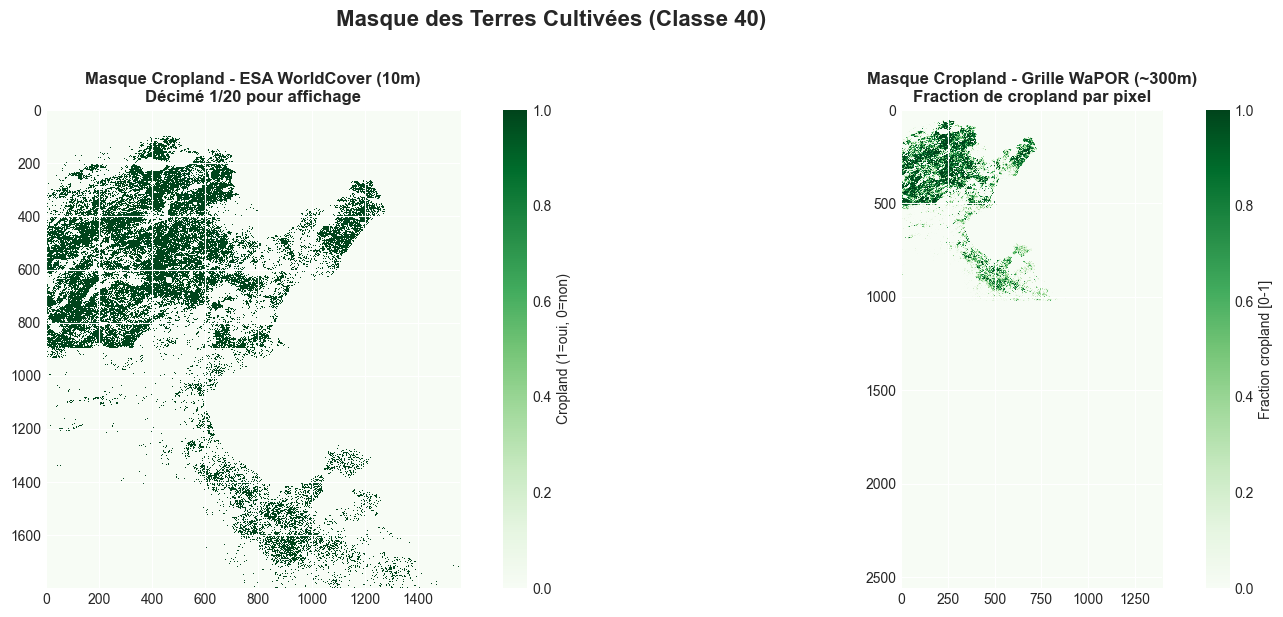


💡 Le masque WaPOR montre la fraction de cropland par pixel (~300m)
   Valeurs entre 0 et 1 représentent la couverture partielle du pixel


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Masque haute résolution (lire décimé directement du fichier)
ax = axes[0]
decimation = 20

with rasterio.open(lcc_file) as src:
    # Lire version décimée directement (out_shape)
    out_shape = (src.height // decimation, src.width // decimation)
    lcc_decimated = src.read(1, out_shape=out_shape)
    cropland_mask_hr_decimated = (lcc_decimated == 40).astype(np.uint8)

im1 = ax.imshow(
    cropland_mask_hr_decimated,
    cmap='Greens',
    interpolation='nearest'
)
ax.set_title('Masque Cropland - ESA WorldCover (10m)\nDécimé 1/20 pour affichage', 
             fontsize=12, fontweight='bold')
plt.colorbar(im1, ax=ax, label='Cropland (1=oui, 0=non)')

# Masque WaPOR
ax = axes[1]
im2 = ax.imshow(
    cropland_mask_wapor,
    cmap='Greens',
    interpolation='nearest'
)
ax.set_title('Masque Cropland - Grille WaPOR (~300m)\nFraction de cropland par pixel', 
             fontsize=12, fontweight='bold')
plt.colorbar(im2, ax=ax, label='Fraction cropland [0-1]')

plt.suptitle('Masque des Terres Cultivées (Classe 40)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Le masque WaPOR montre la fraction de cropland par pixel (~300m)")
print("   Valeurs entre 0 et 1 représentent la couverture partielle du pixel")

## 7. Calculer ETb (Évapotranspiration Bleue) pour une Année

ETb = max(AETI - P_effective, 0) sommé sur l'année

**Note**: Pour cette démonstration, nous utilisons les données annuelles disponibles.
Pour un calcul mensuel complet, il faudrait télécharger les données mensuelles WaPOR.

In [10]:
def calculate_effective_precipitation(P_monthly):
    """
    Calculer les précipitations effectives selon Brouwer & Heibloem (1986)
    
    Parameters:
    -----------
    P_monthly : array-like
        Précipitations mensuelles (mm/mois)
    
    Returns:
    --------
    P_effective : array-like
        Précipitations effectives (mm/mois)
    
    Formula:
    --------
    Si P > 75 mm/mois: P_e = max(0.8 * P - 25, 0)
    Sinon:             P_e = max(0.6 * P - 10, 0)
    """
    P_monthly = np.asarray(P_monthly)
    P_effective = np.zeros_like(P_monthly, dtype=np.float32)
    
    # Cas 1: P > 75 mm
    mask_high = P_monthly > 75
    P_effective[mask_high] = np.maximum(0.8 * P_monthly[mask_high] - 25, 0)
    
    # Cas 2: P <= 75 mm
    mask_low = ~mask_high
    P_effective[mask_low] = np.maximum(0.6 * P_monthly[mask_low] - 10, 0)
    
    return P_effective

# Test de la fonction
test_P = np.array([10, 30, 50, 75, 100, 150, 200])
test_Pe = calculate_effective_precipitation(test_P)

print("📐 Test de la fonction de précipitations effectives:\n")
print("P (mm)  | P_e (mm) | Formule utilisée")
print("-" * 45)
for p, pe in zip(test_P, test_Pe):
    formula = "0.8*P - 25" if p > 75 else "0.6*P - 10"
    print(f"{p:6.0f}  | {pe:8.1f} | {formula}")

print("\n✓ Fonction prête")

📐 Test de la fonction de précipitations effectives:

P (mm)  | P_e (mm) | Formule utilisée
---------------------------------------------
    10  |      0.0 | 0.6*P - 10
    30  |      8.0 | 0.6*P - 10
    50  |     20.0 | 0.6*P - 10
    75  |     35.0 | 0.6*P - 10
   100  |     55.0 | 0.8*P - 25
   150  |     95.0 | 0.8*P - 25
   200  |    135.0 | 0.8*P - 25

✓ Fonction prête


## 8. Visualiser AETI, PCP et ETb

Carte comparative des trois variables

In [12]:
# Année de référence pour le calcul
year = 2020

print(f"💧 Calcul de ETb (Évapotranspiration bleue) - {year}\n")

# Charger AETI annuel (référence spatiale)
et_file = f"{data_dir}/ET/AETI_L1_{year}.tif"
with rasterio.open(et_file) as src:
    aeti_annual = src.read(1).astype(np.float32)
    aeti_annual[aeti_annual < 0] = np.nan
    aeti_profile = src.profile
    aeti_transform = src.transform
    aeti_crs = src.crs

print(f"✓ AETI chargé: {et_file}")
print(f"  Dimensions: {aeti_annual.shape}")

# Charger PCP annuel
pcp_file = f"{data_dir}/PCP/PCP_L1_{year}.tif"
with rasterio.open(pcp_file) as src:
    pcp_raw = src.read(1).astype(np.float32)
    pcp_raw[pcp_raw < 0] = np.nan
    pcp_transform = src.transform
    pcp_crs = src.crs

print(f"✓ PCP chargé: {pcp_file}")
print(f"  Dimensions PCP brutes: {pcp_raw.shape}")

# Vérifier si les dimensions correspondent
if aeti_annual.shape != pcp_raw.shape:
    print(f"\n⚠️ Dimensions différentes! Rééchantillonnage de PCP à la grille AETI...")
    
    # Créer tableau PCP aligné sur AETI
    pcp_annual = np.zeros_like(aeti_annual, dtype=np.float32)
    
    # Reprojeter PCP vers la grille AETI
    reproject(
        source=pcp_raw,
        destination=pcp_annual,
        src_transform=pcp_transform,
        src_crs=pcp_crs,
        dst_transform=aeti_transform,
        dst_crs=aeti_crs,
        resampling=Resampling.bilinear
    )
    
    print(f"✓ PCP rééchantillonné: {pcp_annual.shape}")
else:
    pcp_annual = pcp_raw
    print(f"✓ Dimensions identiques, pas de rééchantillonnage nécessaire")

# Approximation: utiliser directement P_annual comme approximation de P_effective
print("\n⚠️ Note: Calcul simplifié avec données annuelles")
print("   Pour un calcul précis de P_effective, il faut les données mensuelles")
print("   Approximation: P_effective ≈ 0.7 * P_annual (facteur moyen)\n")

# Calculer P_effective (approximation)
pcp_effective = 0.7 * pcp_annual

# Calculer ETb
etb_annual = np.maximum(aeti_annual - pcp_effective, 0)

# Appliquer le masque cropland
etb_cropland = etb_annual * cropland_mask_wapor
etb_cropland[cropland_mask_wapor == 0] = np.nan

print(f"✓ ETb calculé")
print(f"\n📊 Statistiques ETb {year} (sur zones cropland):")
print(f"  Min:     {np.nanmin(etb_cropland):.1f} mm/an")
print(f"  Max:     {np.nanmax(etb_cropland):.1f} mm/an")
print(f"  Moyenne: {np.nanmean(etb_cropland):.1f} mm/an")
print(f"  Médiane: {np.nanmedian(etb_cropland):.1f} mm/an")

# Sauvegarder ETb
etb_output = f"../data/processed/ETb_{year}.tif"
with rasterio.open(etb_output, 'w', **et_profile) as dst:
    dst.write(etb_annual, 1)

print(f"\n💾 ETb sauvegardé: {etb_output}")

💧 Calcul de ETb (Évapotranspiration bleue) - 2020

✓ AETI chargé: ../data/raw/ET/AETI_L1_2020.tif
  Dimensions: (2560, 1399)
✓ PCP chargé: ../data/raw/PCP/PCP_L1_2020.tif
  Dimensions PCP brutes: (149, 81)

⚠️ Dimensions différentes! Rééchantillonnage de PCP à la grille AETI...
✓ PCP rééchantillonné: (2560, 1399)

⚠️ Note: Calcul simplifié avec données annuelles
   Pour un calcul précis de P_effective, il faut les données mensuelles
   Approximation: P_effective ≈ 0.7 * P_annual (facteur moyen)

✓ ETb calculé

📊 Statistiques ETb 2020 (sur zones cropland):
  Min:     0.0 mm/an
  Max:     7158.1 mm/an
  Moyenne: 534.3 mm/an
  Médiane: 110.9 mm/an
✓ PCP rééchantillonné: (2560, 1399)

⚠️ Note: Calcul simplifié avec données annuelles
   Pour un calcul précis de P_effective, il faut les données mensuelles
   Approximation: P_effective ≈ 0.7 * P_annual (facteur moyen)

✓ ETb calculé

📊 Statistiques ETb 2020 (sur zones cropland):
  Min:     0.0 mm/an
  Max:     7158.1 mm/an
  Moyenne: 534.3 mm

c:\SDG641_Tunisia_WaterProductivity\venv\lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)



💾 ETb sauvegardé: ../data/processed/ETb_2020.tif


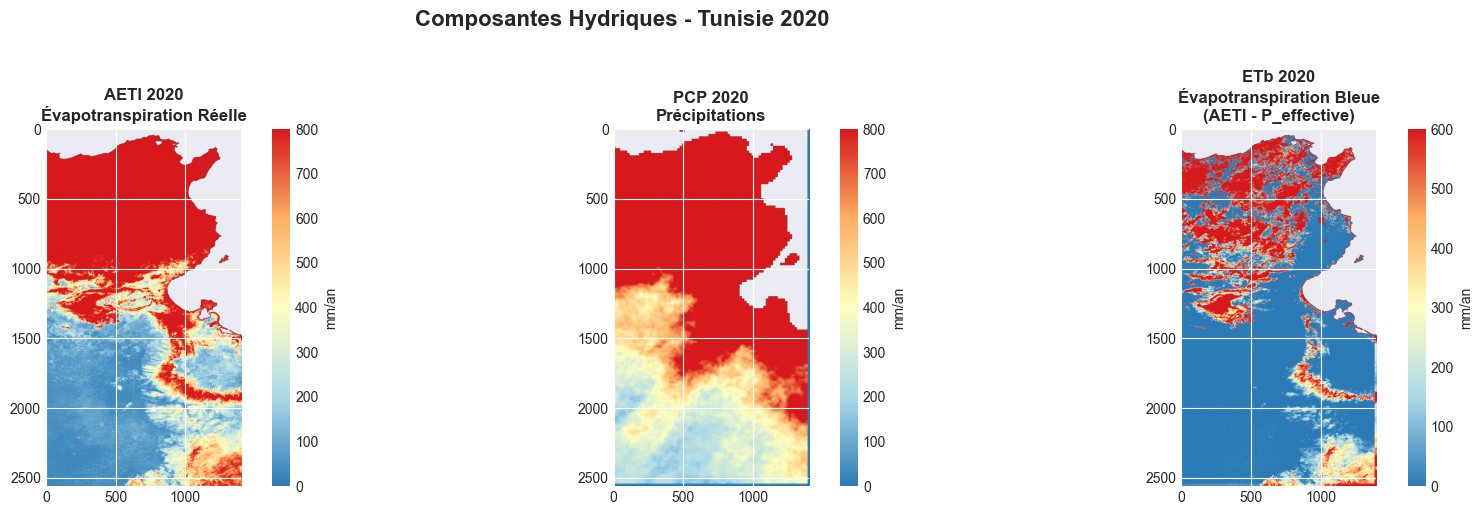


💡 ETb représente l'eau d'irrigation (bleue) utilisée par les cultures
   ETb = max(AETI - P_effective, 0)


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Colormap
colors = ['#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6']
cmap = LinearSegmentedColormap.from_list('water', colors[::-1])

# AETI
im1 = axes[0].imshow(aeti_annual, cmap=cmap, vmin=0, vmax=800)
axes[0].set_title(f'AETI {year}\nÉvapotranspiration Réelle', fontweight='bold')
plt.colorbar(im1, ax=axes[0], label='mm/an')

# PCP
im2 = axes[1].imshow(pcp_annual, cmap=cmap, vmin=0, vmax=800)
axes[1].set_title(f'PCP {year}\nPrécipitations', fontweight='bold')
plt.colorbar(im2, ax=axes[1], label='mm/an')

# ETb
im3 = axes[2].imshow(etb_annual, cmap=cmap, vmin=0, vmax=600)
axes[2].set_title(f'ETb {year}\nÉvapotranspiration Bleue\n(AETI - P_effective)', fontweight='bold')
plt.colorbar(im3, ax=axes[2], label='mm/an')

plt.suptitle(f'Composantes Hydriques - Tunisie {year}', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 ETb représente l'eau d'irrigation (bleue) utilisée par les cultures")
print("   ETb = max(AETI - P_effective, 0)")